# 🍫**Food App - A/B Test**
---

## **Descripción del proyecto**

### 🎯**Contexto**

Nuestra empresa emergente del sector **foodtech** está desarrollando una aplicación para la compra y entrega de productos alimenticios. Uno de los retos clave es **entender cómo los usuarios interactúan con la aplicación** y qué factores influyen en la conversión hacia la compra.  

El análisis se enfoca en dos áreas principales:

1. **Embudo de conversión:**  
   - Identificar cuántos usuarios logran completar el proceso de compra.  
   - Detectar en qué etapas se produce la mayor fricción.  
   - Señalar posibles puntos de optimización para mejorar la conversión.  

2. **Prueba A/A/B de rediseño:**  
   El equipo de diseño propuso un cambio en la tipografía de la aplicación. La hipótesis es que las nuevas fuentes podrían mejorar la experiencia, pero existe el riesgo de que generen rechazo. Para tomar una decisión informada, se implementó un test A/A/B:  
   - Dos grupos de control mantienen la tipografía actual.  
   - Un grupo experimental visualiza la nueva tipografía.  
   El objetivo es determinar si el cambio de diseño impacta de manera positiva o negativa en el comportamiento de los usuarios.  

La creación de **dos grupos de control (A/A)** nos permite validar la consistencia del experimento y detectar posibles sesgos en los datos. Si ambos grupos de control presentan resultados similares, tendremos mayor confianza en las diferencias observadas con el grupo experimental. 


### 🗂️**Descripción de los datos**

Cada registro del dataset corresponde a un **evento generado por un usuario en la aplicación**.  

- `EventName`: tipo de evento registrado (por ejemplo, inicio de sesión, visualización de producto, compra).

- `DeviceIDHash`: identificador único del usuario.

- `EventTimestamp`: marca temporal del evento.

- `ExpId`: identificador del experimento:

  - `246` y `247`: grupos de control (tipografía actual).  
  - `248`: grupo experimental (nueva tipografía).  


### **Paso 1. 📤Abrir el archivo de datos y leer la información general**
---

Ruta de archivo: `/datasets/logs_exp_us.csv`

In [1]:
# Importando librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Cargando archivo csv como DataFrame
actividad = pd.read_csv('datasets/logs_exp_us.csv', sep='\t')

In [3]:
# Exploración general de archivo
display(actividad.head(4))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248


### **Paso 2. 🧹Preparar los datos para el análisis**
---

#### **Renombrando columnas de forma conveniente.**


In [4]:
# Renombrando columnas
actividad.columns = ['event_name','user_id','event_ts','group']

#### **Comprobación de los tipos de datos, valores duplicados y valores ausentes.**

- Valores duplicados:

In [5]:
# Contando el número de registros duplicados
print('Número de registros duplicados:', actividad.duplicated().sum())


Número de registros duplicados: 413


In [6]:
# Eliminando los registros duplicados
actividad = (
    actividad
    .drop_duplicates() # Elimina los registros duplicados
    .reset_index(drop=True) # Reset al índice sin conservar el anterior como columna
)

# Corroborando la eliminación
print('Nuevo número de registros duplicados:', actividad.duplicated().sum())

Nuevo número de registros duplicados: 0


- Tipos de datos y valores ausentes:

In [7]:
# Comprobando los tipos de datos y valores ausentes
print(actividad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   event_ts    243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
None


> ℹ️**No existen datos ausentes en ninguna de las columnas.**ℹ️
> - Es necesario corregir el tipo de dato de la columna 'event_ts', pasando de int64 a datetime.
> - Convertir columna 'event_name' en tipo category para optimizar memoria.

In [8]:
# Convirtiendo columna 'event_ts' al tipo datetime[ns]
actividad['event_ts'] = pd.to_datetime(actividad['event_ts'], unit='s')

In [9]:
# Convirtiendo columna 'event_name' al tipo category
actividad['event_name'] = actividad['event_name'].astype('category')

- Mejorando nombres de grupos:

In [10]:
# Reemplazado el nombre de los grupos por A1, A2 y B
actividad['group'] = (
    actividad['group']
    .replace(
        {246: "A1", 247: "A2", 248: "B"}
    )
)


In [11]:
# Verificando que cada usuario único aparezca únicamente en un grupo.

    # Generando una lista de usuarios únicos para cada grupo
users_A1 = actividad.query("group == 'A1'")['user_id'].unique()
users_A2 = actividad.query("group == 'A2'")['user_id'].unique()
users_B = actividad.query("group == 'B'")['user_id'].unique()

# Lista vacía que almacenará los id repetidos (en caso de existir)
ids_repetidos = []

for id in users_A1:
    if id in users_A2:
        if id not in ids_repetidos:
            ids_repetidos.append(id)
    elif id in users_B:
        if id not in ids_repetidos:
            ids_repetidos.append(id)

for id in users_A2:
    if id in users_B:
        if id not in ids_repetidos:
            ids_repetidos.append(id)

print(f'Número de usuarios en diferentes grupos: {len(ids_repetidos)}')


Número de usuarios en diferentes grupos: 0


#### **Agregando una columna de fecha y hora y una columna separada para las fechas.**

In [12]:
# Agregando columnas
    # Columna 'event_hour' da fecha y hora (sin minutos ni segundos) 
actividad['event_hour'] = actividad['event_ts'].dt.floor('h')

    # Columna 'event_date' da unicamente la fecha del evento
actividad['event_date'] = actividad['event_ts'].dt.date
actividad['event_date'] = pd.to_datetime(actividad['event_date'])

# Reordenando columnas
actividad = actividad[['event_name', 'user_id', 'group', 'event_ts', 'event_hour', 'event_date']]

# Mostrando df
actividad.head(5)

,event_name,user_id,group,event_ts,event_hour,event_date
0,MainScreenAppear,4575588528974610257,A1,2019-07-25 04:43:36,2019-07-25 04:00:00,2019-07-25
1,MainScreenAppear,7416695313311560658,A1,2019-07-25 11:11:42,2019-07-25 11:00:00,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25 11:00:00,2019-07-25
3,CartScreenAppear,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25 11:00:00,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,B,2019-07-25 11:48:42,2019-07-25 11:00:00,2019-07-25


### **Paso 3. 🔍Estudiar y comprobar los datos**
---

#### **¿Cuántos eventos hay en los registros?**

In [13]:
print(f'En total se cuenta con {len(actividad)} registros de eventos ocurridos.')
print('*************************************************************')
print('Número de registros para cada evento:')

display(
    actividad
    .groupby('event_name', as_index=False, observed=False)
    .agg(event_count=('event_ts', 'count'))
)

En total se cuenta con 243713 registros de eventos ocurridos.
*************************************************************
Número de registros para cada evento:


,event_name,event_count
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


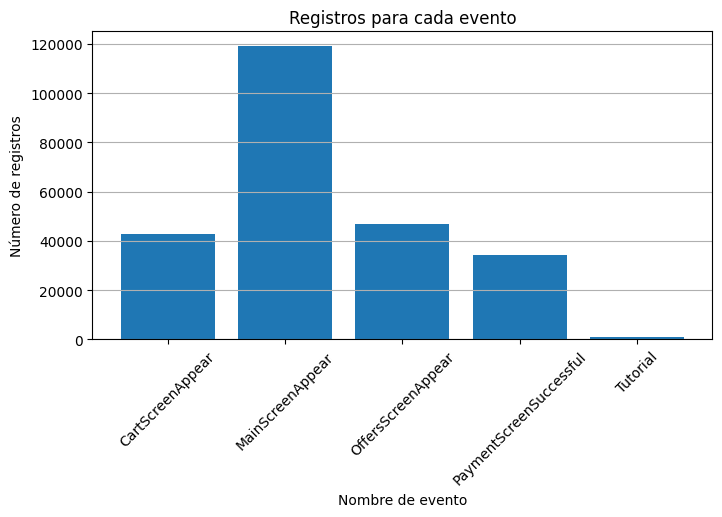

In [14]:
# Graficando número de registros para cada evento:
plt.figure(figsize=(8, 4))

plt.bar(
    actividad.groupby('event_name', as_index=False, observed=False).agg(event_count=('event_ts', 'count'))['event_name'],
    actividad.groupby('event_name', as_index=False, observed=False).agg(event_count=('event_ts', 'count'))['event_count']
)

plt.title('Registros para cada evento')
plt.xlabel('Nombre de evento')
plt.ylabel('Número de registros')
plt.grid(axis='y')
plt.xticks(rotation=45)

plt.show()

#### **¿Cuántos usuarios hay en los registros?**


In [15]:
# Encontrando el numero de usuarios únicos
print(f'''En total se cuenta con {actividad['user_id'].nunique()} usuarios únicos
repartidos en 3 grupos (A1, A2 y B)''')
print('********************************************')

# Agrupando por grupo (A1, A2 y B) y contando el número de usuarios únicos para cada grupo
display(
    actividad
    .groupby('group', as_index=False)
    .agg(no_users=('user_id','nunique'))
)


En total se cuenta con 7551 usuarios únicos
repartidos en 3 grupos (A1, A2 y B)
********************************************


,group,no_users
0,A1,2489
1,A2,2520
2,B,2542


#### **¿Cuál es el promedio de eventos por usuario?**

In [16]:
# Agrupando por id de usuario y contando el número de eventos para cada usuario
events_by_user = (
    actividad
    .groupby('user_id', as_index=False)
    .agg(events_count = ('event_name','count'))
)

display(events_by_user.head(6))

# Calculando el promedio de eventos por usuario
print(f'El promedio general de eventos por usuario es de: {events_by_user['events_count'].mean():.3f}')
print('********************************************************')

,user_id,events_count
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
5,8486814028069281,10


El promedio general de eventos por usuario es de: 32.276
********************************************************


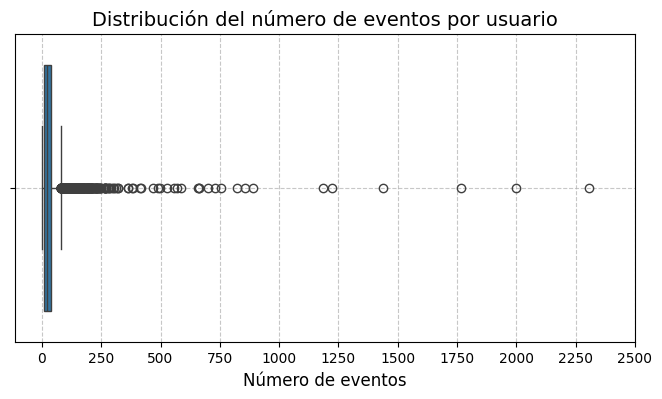

In [17]:
plt.figure(figsize=(8, 4))

sns.boxplot(x=events_by_user['events_count'])

plt.title("Distribución del número de eventos por usuario", fontsize=14)
plt.xlabel("Número de eventos", fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.xticks(range(0, events_by_user['events_count'].max() + 250, 250))



plt.show()

> 🚨 La distribución de eventos por usuario es altamente dispersa y presenta numerosos valores atípicos elevados. La mayoría de los usuarios registra niveles bajos de actividad, mientras que aquellos con actividad significativamente mayor se consideran outliers dentro del conjunto de datos.

In [18]:
# Filtrando df events_by_user por grupo (A1, A2 y B)
events_by_userA1 = events_by_user[events_by_user['user_id'].isin(users_A1)]
events_by_userA2 = events_by_user[events_by_user['user_id'].isin(users_A2)]
events_by_userB = events_by_user[events_by_user['user_id'].isin(users_B)]

# Mostrando el promedio de eventos por usuario para cada uno de los grupos
print(f'El promedio de eventos por usuario en el grupo A1 es de: {events_by_userA1['events_count'].mean():.3f}')
print(f'El promedio de eventos por usuario en el grupo A2 es de: {events_by_userA2['events_count'].mean():.3f}')
print(f'El promedio de eventos por usuario en el grupo B es de: {events_by_userB['events_count'].mean():.3f}')
print('****************************************************************')


El promedio de eventos por usuario en el grupo A1 es de: 32.214
El promedio de eventos por usuario en el grupo A2 es de: 30.933
El promedio de eventos por usuario en el grupo B es de: 33.667
****************************************************************


#### **¿Qué periodo de tiempo cubren los datos?**


Se propone realizar un análisis temporal de los datos para identificar a partir de qué fecha los registros son realmente representativos. Esto permite determinar el periodo en el que los datos están completos y relevantes, evitando sesgos causados por eventos antiguos o incompletos.

In [19]:
# Fecha máxima
date_max = actividad['event_date'].max()
# Fecha mínima
date_min = actividad['event_date'].min()

print(f'El periodo comprende del {date_min} al {date_max}')

El periodo comprende del 2019-07-25 00:00:00 al 2019-08-07 00:00:00


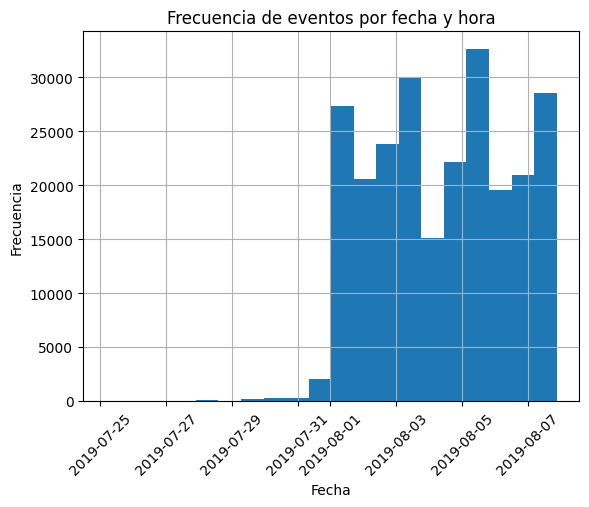

In [20]:
# Graficando histograma
plt.hist(
    actividad['event_hour'],
    bins=20
)

plt.title('Frecuencia de eventos por fecha y hora')
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

ℹ️ A partir de el histograma se concluye que **no se cuenta con datos completos para todo el periodo.** Los datos comienzan a estar completos a partir del día **1 de Agosto de 2019** ℹ️



In [21]:
# Filtrando datos, trabajar únicamente con lo datos que vayan del 2019-08-01 al 2019-08-07
actividad_efectiva = actividad.query('event_date >= "2019-08-01"')
display(actividad_efectiva.head())

,event_name,user_id,group,event_ts,event_hour,event_date
2826,Tutorial,3737462046622621720,A1,2019-08-01 00:07:28,2019-08-01,2019-08-01
2827,MainScreenAppear,3737462046622621720,A1,2019-08-01 00:08:00,2019-08-01,2019-08-01
2828,MainScreenAppear,3737462046622621720,A1,2019-08-01 00:08:55,2019-08-01,2019-08-01
2829,OffersScreenAppear,3737462046622621720,A1,2019-08-01 00:08:58,2019-08-01,2019-08-01
2830,MainScreenAppear,1433840883824088890,A2,2019-08-01 00:08:59,2019-08-01,2019-08-01


#### **¿Se pierden muchos eventos y usuarios al excluir los datos más antiguos?**


In [22]:
# Creando df que compara la cuenta de eventos para cada evento antes y después del filtrado
event_count_comparison = pd.merge(
    actividad
        .groupby('event_name', as_index=False, observed=False)
        .agg(event_count=('event_ts', 'count')),
    
    actividad_efectiva
        .groupby('event_name', as_index=False, observed=False)
        .agg(event_count=('event_ts', 'count')),
    
    on='event_name',
    how='left',
    suffixes=('', '_filtered')
)


# Calculando cuantos registros se perdieron para cada evento
event_count_comparison['events_lost'] = event_count_comparison['event_count'] - event_count_comparison['event_count_filtered']

print(f'Después del filtrado, en total se cuenta con {len(actividad_efectiva)} registros de eventos ocurridos.')
print(f'Se perdieron en total {event_count_comparison['events_lost'].sum()} eventos.')
print('*************************************************************')
display(event_count_comparison)




Después del filtrado, en total se cuenta con 240887 registros de eventos ocurridos.
Se perdieron en total 2826 eventos.
*************************************************************


,event_name,event_count,event_count_filtered,events_lost
0,CartScreenAppear,42668,42303,365
1,MainScreenAppear,119101,117328,1773
2,OffersScreenAppear,46808,46333,475
3,PaymentScreenSuccessful,34118,33918,200
4,Tutorial,1018,1005,13


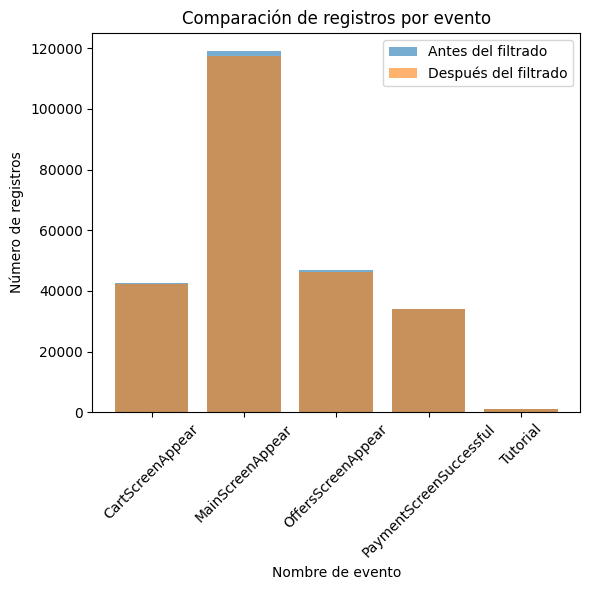

In [23]:
# Gráfico combinado
plt.figure(figsize=(6, 6))

plt.bar(event_count_comparison['event_name'], event_count_comparison['event_count'], alpha=0.6, label='Antes del filtrado')
plt.bar(event_count_comparison['event_name'], event_count_comparison['event_count_filtered'], alpha=0.6, label='Después del filtrado')

plt.title('Comparación de registros por evento')
plt.xlabel('Nombre de evento')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

>ℹ️ **NO se pierde una cantidad significativa de eventos.** ℹ️

In [24]:
# Encontrando el numero de usuarios únicos después del filtrado
print(f'''Después del filtrado, en total se cuenta con {actividad_efectiva['user_id'].nunique()} usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)''')
print('********************************************')

users_count = pd.merge(
    actividad
        .groupby('group', as_index=False)
        .agg(no_users = ('user_id','nunique')),
    
    actividad_efectiva
        .groupby('group', as_index=False)
        .agg(no_users = ('user_id','nunique')),
    
    on='group', how='left', suffixes=('', '_filtered')
)

users_count['users_lost'] = users_count['no_users'] - users_count['no_users_filtered']

display(users_count)

Después del filtrado, en total se cuenta con 7534 usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)
********************************************


,group,no_users,no_users_filtered,users_lost
0,A1,2489,2484,5
1,A2,2520,2513,7
2,B,2542,2537,5


>ℹ️ **NO se pierde una cantidad significativa de usuarios.** ℹ️

### **Paso 4. 🧩Estudiar el embudo de eventos**
---

#### **Eventos en los registros y su frecuencia de suceso.**


In [25]:
# Calculando la frecuencia de cada evento, ordenando de mayor a menor
actividad_efectiva['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

#### **Cantidad de usuarios que realizaron cada una de estas acciones.**

Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [26]:
# Calculando la cantidad total de usuarios únicos
total_users = actividad_efectiva['user_id'].nunique()
print(f'En total se cuenta con {total_users} usuarios.')

# Calculando la frecuencia de cada evento y cantidad de usuarios para cada evento, ordenando de mayor a menor
events_count = (
    actividad_efectiva
    .groupby('event_name', as_index=False, observed=False)
    .agg(
        unique_users=('user_id', 'nunique'),
        event_count=('event_ts', 'count')
    )
    .sort_values('unique_users', ascending=False)
)

# Calculando proporción de usuarios que realizaron la acción al menos una vez
events_count['user_proportion'] = events_count['unique_users'] / total_users

display(events_count)


En total se cuenta con 7534 usuarios.


,event_name,unique_users,event_count,user_proportion
1,MainScreenAppear,7419,117328,0.984736
2,OffersScreenAppear,4593,46333,0.609636
0,CartScreenAppear,3734,42303,0.495620
3,PaymentScreenSuccessful,3539,33918,0.469737
4,Tutorial,840,1005,0.111495


#### **¿En qué orden ocurrieron las acciones? ¿Todas son parte de una sola secuencia?**


>ℹ️ Parece ser que el orden de los eventos es el siguiente: ℹ️
>
>1. **MainScreenAppear** (Aparición de la pantalla principal)
>2. **OffersScreenAppear** (Pantalla de ofertas)
>3. **CartScreenAppear** (Pantalla de carrito de compras)
>4.  **PaymentScreenSuccessful** (Pantalla de compra exitosa)
>
>Por otro lado, también se ha registrado el evento "Tutorial" que parece ser un evento que no forma parte de la secuencia.

> La idea es analizar cómo los usuarios avanzan a través de las distintas etapas de nuestra aplicación.
>
> Para cada evento en la secuencia, calculo la proporción de usuarios que pasan al siguiente paso, es decir, cuántos de los que llegaron a la etapa anterior efectivamente alcanzan la siguiente. Por ejemplo, si tenemos los eventos A → B → C, calculo la proporción de usuarios en B respecto a A, y la proporción en C respecto a B. Esto nos da una visión clara del embudo de conversión.



In [27]:
# Funcion para crear embudo de eventos
def create_funnel(events_full):
    # Pasos del embudo en orden
    funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    
    # Conteo global por pasos
    global_step_counts = [0] * len(funnel_steps)

    # Agrupar por usuario
    for user_id, user_data in events_full.groupby('user_id'):
        user_data = user_data.sort_values(by='event_ts', ascending=True)  # Asegurar orden temporal
        
        # Contadores por usuario
        step_counts = [0] * len(funnel_steps) # Conteo de pasos alcanzados en orden
        current_step = 0 # Contador índice

        # Recorrer cada fila de cada usuario
        for _, row in user_data.iterrows():
            event = row['event_name'] # Extrayendo valores de columna 'event_name'
            expected_event = funnel_steps[current_step] # Variable para comparar el paso actual

            if event == expected_event: # Si el valor de event es igual al paso actual...
                step_counts[current_step] += 1 # Sumar 1 al índice correspondiente al paso actual
                current_step += 1 # Avanzar al siguente paso

                if current_step == len(funnel_steps): # Si se supera el último paso...
                    current_step = 0  # Reiniciar

            elif event == funnel_steps[0]: # Si reinicia desde MainScreenAppear
                step_counts[0] += 1 # Suma 1 a la etapa 'MainScreenAppear' 
                current_step = 1 # Asigna la segunda etapa como paso actual

        # Agregar conteo de este usuario al total
        for i in range(len(global_step_counts)):
            global_step_counts[i] += step_counts[i]

    # Crear el DataFrame (embudo)
    events_funnel = pd.DataFrame({
        'event_name': funnel_steps,
        'sequential_users': global_step_counts
    })

    # Calculando métricas
        # Tasa de conversión de una etapa a la siguente
    events_funnel['conversion_rate'] = (
        events_funnel['sequential_users'] / events_funnel['sequential_users'].shift(1)
    ).fillna(1)
        # Usuarios perdidos de una etapa a otra
    events_funnel['users_lost'] = (
        events_funnel['sequential_users'].shift(1) - events_funnel['sequential_users']
    ).fillna(0)
        # Tasa de conversión desde el inicio
    events_funnel['conversion_from_start'] = (
        events_funnel['sequential_users'] / events_funnel['sequential_users'][0]
    )

    return events_funnel

In [28]:
# Ejecutando la función con el dataframe general
general_funnel = create_funnel(actividad_efectiva)

display(general_funnel)

,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,117328,1.000000,0.0,1.000000
1,OffersScreenAppear,24495,0.208774,92833.0,0.208774
2,CartScreenAppear,7154,0.292060,17341.0,0.060974
3,PaymentScreenSuccessful,4003,0.559547,3151.0,0.034118


#### **¿En qué etapa pierdes más usuarios?**


> ℹ️ La mayor caída en términos de tasa de conversión ocurre entre las etapas **MainScreenAppear y OffersScreenAppear**, con solo un **20.87%** de los usuarios avanzando a la página de ofertas. ℹ️ Esto indica que la página de ofertas podría no resultar atractiva para los usuarios, o que el botón de acceso no está suficientemente destacado.
>
> ℹ️ En términos absolutos, la mayor pérdida de usuarios también ocurre entre **MainScreenAppear y OffersScreenAppear**, donde se pierden 92,833 ℹ️
>
> ℹ️La tasa de conversión mas alta se da entre las etapas **CartScreenAppear y PaymentScreenSuccessful** con un **55.95%** ℹ️

#### **¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?**

>ℹ️ Solo el **3.4%** de los usuarios hacen todo el viaje desde su primer evento hasta el pago ℹ️

### **Paso 5. 📊Estudiar los resultados del experimento**
---

#### **¿Cuántos usuarios hay en cada grupo?**


In [29]:
# Separando los registros por grupo
actividad_A1 = actividad_efectiva.query("group == 'A1'")
actividad_A2 = actividad_efectiva.query("group == 'A2'")
actividad_B = actividad_efectiva.query("group == 'B'")

# Generando una lista de usuarios únicos para cada grupo
users_A1 = actividad_A1['user_id'].unique()
users_A2 = actividad_A2['user_id'].unique()
users_B = actividad_B['user_id'].unique()

# Mostrando candidad de usuarios para cada grupo
display(actividad_efectiva.groupby('group', as_index=False).agg({'user_id':'nunique'}))

,group,user_id
0,A1,2484
1,A2,2513
2,B,2537


#### **Test A/A**


>En la fase de validación del experimento A/A se analizaron dos grupos de control (A1 y A2) con el objetivo de comprobar la consistencia de los cálculos y descartar posibles sesgos. Para ello, se compararon ambas muestras y se revisó si existían diferencias estadísticamente significativas.
>
>A continuación, se identificó el evento con mayor frecuencia de participación y se evaluó cómo se comportaba en cada grupo: cuántos usuarios lo realizaron y qué proporción representaban dentro del total. Con esta información, se aplicó un Z-test que permitió confirmar si las diferencias observadas entre A1 y A2 eran relevantes o no desde el punto de vista estadístico.
>
>Finalmente, este mismo enfoque se replicó en el resto de los eventos, apoyándonos en una función diseñada para optimizar el análisis y acelerar el procesamiento de los resultados.



In [30]:
# Creando embudos a partir de la función "create_funnel()" antes definida:
funnel_A1 = create_funnel(actividad_A1)
print('Embudo grupo A1')
display(funnel_A1)

funnel_A2 = create_funnel(actividad_A2)
print('Embudo grupo A2')
display(funnel_A2)

Embudo grupo A1


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,37676,1.000000,0.0,1.000000
1,OffersScreenAppear,8003,0.212416,29673.0,0.212416
2,CartScreenAppear,2380,0.297388,5623.0,0.063170
3,PaymentScreenSuccessful,1345,0.565126,1035.0,0.035699


Embudo grupo A2


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,39090,1.000000,0.0,1.000000
1,OffersScreenAppear,8009,0.204886,31081.0,0.204886
2,CartScreenAppear,2261,0.282307,5748.0,0.057841
3,PaymentScreenSuccessful,1246,0.551084,1015.0,0.031875


In [31]:
# Función para realizar test de tasas de conversión.
def ztest_conversion_control (grupo1, grupo2, etapa:int, alpha:float):
    """
    Realiza una prueba Z de proporciones para comparar las tasas de conversión entre dos grupos
    en una etapa específica de un embudo secuencial.

    Parámetros:
    - grupo1 (DataFrame): DataFrame que contiene una columna 'sequential_users' con los conteos acumulados por etapa.
    - grupo2 (DataFrame): DataFrame similar al grupo1, con la misma estructura.
    - etapa (int): Índice de la etapa a evaluar. Debe ser >= 0 y menor que la longitud de los datos.
    - alpha (float): Nivel de significacia estadística.

    Lógica:
    - Si etapa == 0: Lanza advertencia ya que no tiene sentido comparar tasas de conversión sin transición y termina la ejecución de la función.
    - Si etapa > 0: compara la proporción de usuarios que pasan de la etapa anterior a la actual.
    - Si etapa no existe: muestra un mensaje de error y detiene la ejecución.

    La función imprime el estadístico Z, el valor p y un mensaje indicando si la diferencia es estadísticamente significativa.
    """
    # Éxitos y totales por grupo
    if etapa == 0:
        print("⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.")
        return
    elif (etapa > 0) and (etapa < len(grupo1)):
        exitos = [grupo1['sequential_users'][etapa], grupo2['sequential_users'][etapa]]
        totales = [grupo1['sequential_users'][etapa - 1], grupo2['sequential_users'][etapa - 1]]
    else:
        print(f'❌¡ERROR! No existe la etapa {etapa}')
        return
    
    # Prueba Z de proporciones
    stat, p_value = proportions_ztest(exitos, totales)

    print(f'- Estadístico Z: {stat:.3f}')
    print(f'- Valor p: {p_value:.3f}')

    if p_value < alpha:
        print("✅ Se rechaza la hipótesis nula, existe diferencia significativa en tasas de conversión.")
    else:
        print("❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.")

**Prueba A/A** 
(A1/A2)

- **Hipótesis nula:** No existen diferencias significativas en tasas de conversión.
- **Hipótesis alternativa:** Existen diferencias significativas en tasas de conversión.
---

In [32]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][0]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 0, 0.05)


Test estadístico para la etapa "MainScreenAppear" - A1 vs A2:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [33]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 1, 0.05)


Test estadístico para la etapa "OffersScreenAppear" - A1 vs A2:
- Estadístico Z: 2.567
- Valor p: 0.010
✅ Se rechaza la hipótesis nula, existe diferencia significativa en tasas de conversión.


In [34]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 2, 0.05)

Test estadístico para la etapa "CartScreenAppear" - A1 vs A2:
- Estadístico Z: 2.103
- Valor p: 0.035
✅ Se rechaza la hipótesis nula, existe diferencia significativa en tasas de conversión.


In [35]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 3, 0.05)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs A2:
- Estadístico Z: 0.963
- Valor p: 0.336
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


>ℹ️Se detectan diferencias estadísticamente significativas en las tasas de conversión en las etapas:
>
>- MainScreenAppear → OffersScreenAppear
>- OffersScreenAppear → CartScreenAppear
>
>ℹ️Estos resultados indican que los grupos no se comportaron de manera equivalente en dichos puntos del embudo.
>
>ℹ️En la etapa final CartScreenAppear → PaymentScreenSuccessful no se observan diferencias.
>
>ℹ️Los grupos de control no presentan un comportamiento del todo constante.

#### **Test A/B**

> Se repitió el análisis para el grupo con fuentes alteradas, contrastando sus resultados con los obtenidos en cada grupo de control por separado y también frente a los controles combinados. A partir de esta comparación fue posible identificar las diferencias y extraer conclusiones sobre el experimento.



In [36]:
# Definiendo función para realizar test de tasas de conversión.
def ztest_conversion (grupo1, grupo2, etapa:int, alpha:float):
    """
    Realiza una prueba Z de proporciones para comparar las tasas de conversión entre dos grupos
    en una etapa específica de un embudo secuencial.

    Parámetros:
    - grupo1 (DataFrame): DataFrame con datos de control que contiene una columna 'sequential_users' con los conteos acumulados por etapa.
    - grupo2 (DataFrame): DataFrame con datos de fuentes alteradas, con la misma estructura que grupo1.
    - etapa (int): Índice de la etapa a evaluar. Debe ser >= 0 y menor que la longitud de los datos.
    - alpha (float): Nivel de significacia estadística.

    Lógica:
    - Si etapa == 0: Lanza advertencia ya que no tiene sentido comparar tasas de conversión sin transición y termina la ejecución de la función.
    - Si etapa > 0: compara la proporción de usuarios que pasan de la etapa anterior a la actual.
    - Si etapa no existe: muestra un mensaje de error y detiene la ejecución.

    La función imprime el estadístico Z, el valor p y un mensaje indicando si la diferencia es estadísticamente significativa (α = 0.05).
    """
    # Éxitos y totales por grupo
    if etapa == 0:
        print("⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.")
        return
    elif (etapa > 0) and (etapa < len(grupo1)):
        exitos = [grupo1['sequential_users'][etapa], grupo2['sequential_users'][etapa]]
        totales = [grupo1['sequential_users'][etapa - 1], grupo2['sequential_users'][etapa - 1]]
    else:
        print(f'❌¡ERROR! No existe la etapa {etapa}')
        return
    
    # Prueba Z de proporciones
    stat, p_value = proportions_ztest(exitos, totales)

    print(f'- Estadístico Z: {stat:.3f}')
    print(f'- Valor p: {p_value/2:.3f}')


    if ((p_value/2) < alpha) and (grupo1['conversion_rate'][etapa] < grupo2['conversion_rate'][etapa]):
        print("✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.")
    else:
        print("❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.")

**A1/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1.
---

In [37]:
print('Embudo grupo A1:')
display(funnel_A1)

funnel_B = create_funnel(actividad_B)
print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A1:


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,37676,1.000000,0.0,1.000000
1,OffersScreenAppear,8003,0.212416,29673.0,0.212416
2,CartScreenAppear,2380,0.297388,5623.0,0.063170
3,PaymentScreenSuccessful,1345,0.565126,1035.0,0.035699


Embudo grupo B:


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,40562,1.000000,0.0,1.000000
1,OffersScreenAppear,8483,0.209137,32079.0,0.209137
2,CartScreenAppear,2513,0.296240,5970.0,0.061955
3,PaymentScreenSuccessful,1412,0.561878,1101.0,0.034811


In [38]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][0]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 0, 0.05)

Test estadístico para la etapa "MainScreenAppear" - A1 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [39]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 1, 0.05)

Test estadístico para la etapa "OffersScreenAppear" - A1 vs B:
- Estadístico Z: 1.124
- Valor p: 0.131
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [40]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 2, 0.05)

Test estadístico para la etapa "CartScreenAppear" - A1 vs B:
- Estadístico Z: 0.161
- Valor p: 0.436
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [41]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 3, 0.05)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs B:
- Estadístico Z: 0.229
- Valor p: 0.409
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


>ℹ️ Al realizar la prueba de hipótesis entre A1/B, **no se observan diferencias significativas en las tasas de conversión en ninguna de las etapas.** ℹ️

**A2/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A2.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A2.
---

In [42]:
print('Embudo grupo A2:')
display(funnel_A2)

print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A2:


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,39090,1.000000,0.0,1.000000
1,OffersScreenAppear,8009,0.204886,31081.0,0.204886
2,CartScreenAppear,2261,0.282307,5748.0,0.057841
3,PaymentScreenSuccessful,1246,0.551084,1015.0,0.031875


Embudo grupo B:


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,40562,1.000000,0.0,1.000000
1,OffersScreenAppear,8483,0.209137,32079.0,0.209137
2,CartScreenAppear,2513,0.296240,5970.0,0.061955
3,PaymentScreenSuccessful,1412,0.561878,1101.0,0.034811


In [43]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][0]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 0, 0.05)

Test estadístico para la etapa "MainScreenAppear" - A2 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [44]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][1]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 1, 0.05)

Test estadístico para la etapa "OffersScreenAppear" - A2 vs B:
- Estadístico Z: -1.480
- Valor p: 0.069
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [45]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][2]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 2, 0.05)

Test estadístico para la etapa "CartScreenAppear" - A2 vs B:
- Estadístico Z: -1.972
- Valor p: 0.024
✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.


In [46]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][3]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 3, 0.05)

Test estadístico para la etapa "PaymentScreenSuccessful" - A2 vs B:
- Estadístico Z: -0.750
- Valor p: 0.227
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


ℹ️ Al realizar la prueba de hipótesis entre A2/B, **se observa diferencia significativa en las tasas de conversión para la etapa OffersScreenAppear → CartScreenAppear** ℹ️

‼️ La tasa de conversión en el grupo B es ligeramente mayor a la tasa del conversión del grupo A2.

**A1+A2/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1&A2 (datos combinados).
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1&A2 (datos combinados).
 ---

In [47]:
# Uniendo actividad de los dos grupos de control
actividad_A1_A2 = actividad_efectiva.query("group in ['A1','A2']")
# Creando embudo considerando ambos grupos de control como uno solo
funnel_A1_A2 = create_funnel(actividad_A1_A2)

In [48]:
print('Embudo grupo A (Combinado):')
display(funnel_A1_A2)
print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A (Combinado):


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,76766,1.000000,0.0,1.000000
1,OffersScreenAppear,16012,0.208582,60754.0,0.208582
2,CartScreenAppear,4641,0.289845,11371.0,0.060456
3,PaymentScreenSuccessful,2591,0.558285,2050.0,0.033752


Embudo grupo B:


,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,40562,1.000000,0.0,1.000000
1,OffersScreenAppear,8483,0.209137,32079.0,0.209137
2,CartScreenAppear,2513,0.296240,5970.0,0.061955
3,PaymentScreenSuccessful,1412,0.561878,1101.0,0.034811


In [49]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][0]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 0, 0.05)

Test estadístico para la etapa "MainScreenAppear" - A1 & A2 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [50]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][1]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 1, 0.05)

Test estadístico para la etapa "OffersScreenAppear" - A1 & A2 vs B:
- Estadístico Z: -0.222
- Valor p: 0.412
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [51]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][2]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 2, 0.05)

Test estadístico para la etapa "CartScreenAppear" - A1 & A2 vs B:
- Estadístico Z: -1.047
- Valor p: 0.148
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [52]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][3]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 3, 0.05)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 & A2 vs B:
- Estadístico Z: -0.292
- Valor p: 0.385
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


>ℹ️ Al realizar la prueba de hipótesis entre A/B, **no se observa diferencia significativa en las tasas de conversión en ninguna de las etapas del embudo.** ℹ️

### **Ajuste de valor de significacia estadísitica**
---

>ℹ️ Se han reaizado **12 pruebas de hipótesis estadística con un nivel de significancia alpha de 0.05**. Esto implica que la probabilidad de obtener al menos un falso positivo (rechazar incorrectamente la hipótesis nula) es de aproximadamente 46%. ℹ️
>
>Es necesario realizar un ajuste al nivel de significancia alpha con el método de Corrección de Bonferroni: dividiendo el valor de alpha entre el número de pruebas (0.05 / 12), obteniendo un nuevo valor alpha de 0.00417.
>
>Este nuevo valor de α es muy estricto, lo que reduce considerablemente la probabilidad de falsos positivos, pero **aumenta el riesgo de falsos negativos**, es decir, de no detectar diferencias que realmente existen.

**Prueba A/A** 
(A1/A2)

- **Hipótesis nula:** No existen diferencias significativas en tasas de conversión.
- **Hipótesis alternativa:** Existen diferencias significativas en tasas de conversión.
---

In [53]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 1, 0.00417)

Test estadístico para la etapa "OffersScreenAppear" - A1 vs A2:
- Estadístico Z: 2.567
- Valor p: 0.010
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


In [54]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 2, 0.00417)

Test estadístico para la etapa "CartScreenAppear" - A1 vs A2:
- Estadístico Z: 2.103
- Valor p: 0.035
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


In [55]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 3, 0.00417)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs A2:
- Estadístico Z: 0.963
- Valor p: 0.336
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


**A1/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1.
---

In [56]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 1, 0.00417)

Test estadístico para la etapa "OffersScreenAppear" - A1 vs B:
- Estadístico Z: 1.124
- Valor p: 0.131
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [57]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 2, 0.00417)

Test estadístico para la etapa "CartScreenAppear" - A1 vs B:
- Estadístico Z: 0.161
- Valor p: 0.436
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [58]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 3, 0.00417)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs B:
- Estadístico Z: 0.229
- Valor p: 0.409
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


**A2/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A2.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A2.
---

In [59]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][1]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 1, 0.00417)

Test estadístico para la etapa "OffersScreenAppear" - A2 vs B:
- Estadístico Z: -1.480
- Valor p: 0.069
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [60]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][2]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 2, 0.00417)

Test estadístico para la etapa "CartScreenAppear" - A2 vs B:
- Estadístico Z: -1.972
- Valor p: 0.024
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [61]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][3]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 3, 0.00417)

Test estadístico para la etapa "PaymentScreenSuccessful" - A2 vs B:
- Estadístico Z: -0.750
- Valor p: 0.227
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


**A/B Test:**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1&A2 (datos combinados).
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1&A2 (datos combinados).
---

In [62]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][1]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 1, 0.00417)

Test estadístico para la etapa "OffersScreenAppear" - A1 & A2 vs B:
- Estadístico Z: -0.222
- Valor p: 0.412
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [63]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][2]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 2, 0.00417)

Test estadístico para la etapa "CartScreenAppear" - A1 & A2 vs B:
- Estadístico Z: -1.047
- Valor p: 0.148
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


In [64]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][3]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 3, 0.00417)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 & A2 vs B:
- Estadístico Z: -0.292
- Valor p: 0.385
❌ No es posible rechazar la hipótesis nula, no existe diferencia significativa en tasas de conversión.


>**Resultados de A/B test:**
>
>🧠 Después de realizadas las pruebas de hipótesis con el nivel de significancia ajustado, se concluye que **no existen diferencias significativas en las tasas de conversión entre los grupos A (control) y B (prueba).**

### 🧠**Conclusiones**
---

>1. Se realizaron múltiples A/B tests para evaluar diferencias en métricas clave entre los distintos grupos experimentales.
>
>2. Para controlar el error tipo I debido a comparaciones múltiples, se aplicó un ajuste de nivel de significancia (α ajustado).
>
>3. En particular, los resultados del test principal A/B indican que no existen diferencias estadísticamente significativas en las tasas de conversión entre los grupos A (control) y B (prueba).
>
>4. Los tests adicionales (A1/A2 y A2/B) mostraron valores p menores a 0.05 en análisis iniciales, pero al aplicar la corrección por comparaciones múltiples, estas diferencias no se consideran estadísticamente significativas.
>
>5. En general, los cambios evaluados no generan un efecto medible sobre las métricas analizadas.